---

<center>
<h1>Pronóstico de la productividad forrajera </h1>
<h1>en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook aims to study the use of neural networks as a tool for predicting net primary production (PPN) in the grasslands of the Río de la Plata.

The forecasts will be based on the dynamics of endogenous conditions (PPNA and BHC of previous periods) and exogenous factors (precipitation, temperature, 
and evapotranspiration from previous periods, as well as climate model projections). The final conditions for generation will be estimated ad hoc, while 
the exogenous factors will be extracted from public domain databases.

Based on these models, the objective is to achieve more efficient and precise management of livestock resources.

---

# Modules 

This section contains the import statements for external and in house Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [1]:
### Load the modules ### 
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets

### Load In-House modules ###  
sys.path.append('../src/')
import data
import reporting
import models


--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [2]:
PPNA_FILE = 'PPNA_denso_16d_fechas_ordenadas.csv'
TEMP_FILE = 'TEMP_denso_16d_fechas_ordenadas.csv'
PPT_FILE  = 'PPT_denso_16d_fechas_ordenadas.csv'
DATE_FILE = 'fechas modis ANII.csv'
CORD_FILE = 'xy_denso.csv'

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [13]:
ppna_df = data.ppna_database_ingest(PPNA_FILE)
temp_df = data.temp_database_ingest(TEMP_FILE)
ppt_df = data.ppt_database_ingest(PPT_FILE)
date_df = data.date_database_ingest(DATE_FILE)
cord_df = data.cord_database_ingest (CORD_FILE)
ppna_df = data.DataManager(data.merge_databases(ppna_df,temp_df,ppt_df,cord_df,date_df))
ppna_df.info()

<class 'data.data_manager.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ppna       690000 non-null  float64       
 1   temp       690000 non-null  float64       
 2   ppt        690000 non-null  float64       
 3   date       690000 non-null  datetime64[ns]
 4   latitude   690000 non-null  float64       
 5   longitude  690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 31.6 MB



## Data Visualization 


In [5]:
ppna_df.head()

,ppna,temp,ppt,date,latitude,longitude
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.83242
1,362.433361,23.921929,91.647396,2001-01-17,-31.544792,-56.83242
2,420.441046,24.132180,80.999538,2001-02-02,-31.544792,-56.83242
3,335.261458,26.170466,88.673292,2001-02-18,-31.544792,-56.83242
4,301.399079,24.043910,5.496469,2001-03-06,-31.544792,-56.83242


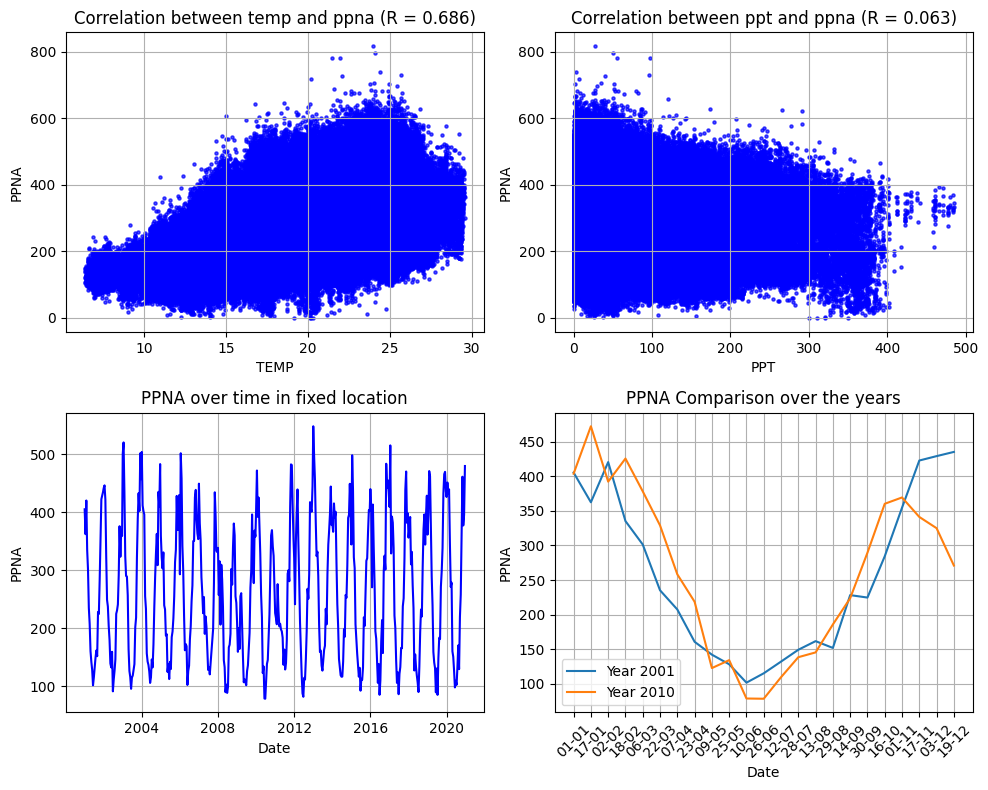

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

reporting.show_correlation(ppna_df, axes[0,0], 'temp', 'ppna')
reporting.show_correlation(ppna_df, axes[0,1], 'ppt', 'ppna')
reporting.show_ppna_fixed_position(ppna_df, axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
reporting.show_ppna_year_comparision_fixed_position(ppna_df,axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

In [ ]:
reporting.show_heat_map(ppna_df)

## Data Management

### Data featuring


Time in seconds isn't the most helpful input for our model, especially when dealing with meteorological data, 
which tends to exhibit periodic patterns. To better understand these patterns, we employ Fourier analysis, revealing a distinct annual cycle.

Addressing this periodicity involves various strategies. Our approach involves transforming date inputs into sine and cosine functions. 
Through prior examination, we've determined that the most significant time dependency occurs on an annual basis. Consequently, we'll utilize a time signal with an annual period.

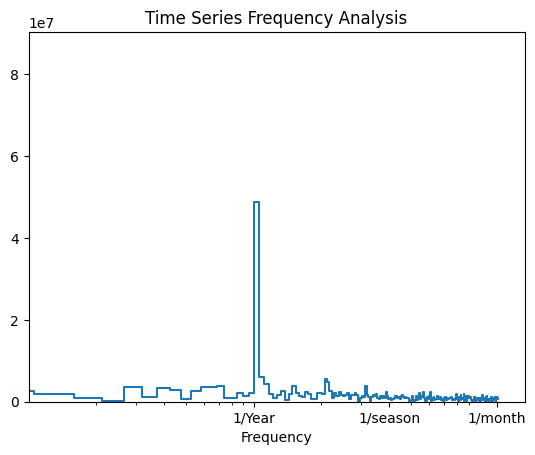

Text(0.5, 1.0, 'Time signal')

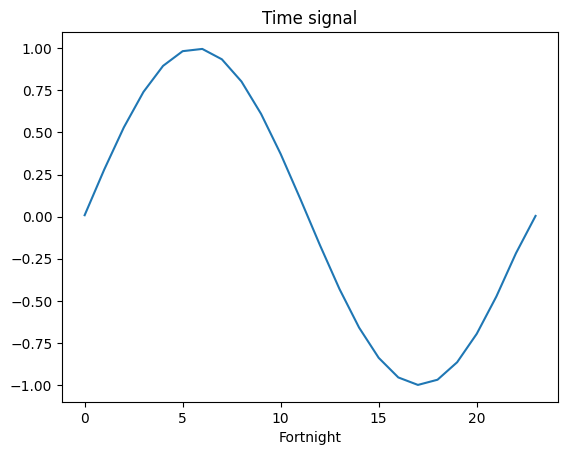

In [4]:
#Convert from date to timestamp format
ppna_df.date_to_timestamp()

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset


plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:24]) #25 samples is nearly a year (15 * 24 = 360 days) and is shown to represent a full period of the temporal signal.
plt.xlabel('Fortnight')
plt.title('Time signal')


### Train, Validation and Test

Afterwards, the dataframe are divided into three sections (train, test, validation) with roughly a 70-20-10 distribution. As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%, 20% and 10%). The samples are divided secuentially to improve the RNN performance, following a training - validation - testing order.

- The **training set** is going to be fed to the model in order for it to learn the distinctive patterns and causalities for the input data and the future ppna.

- The **validation set** provides a way for the model to evaluate it's predictive capability and check if it is not just learning how to handle training data.

- The **testing set** is used further along the way, as a way to test the model's predictive effectieness with data that it has never seen before.

The resulting distribution of the dataset will resemble the following graph.

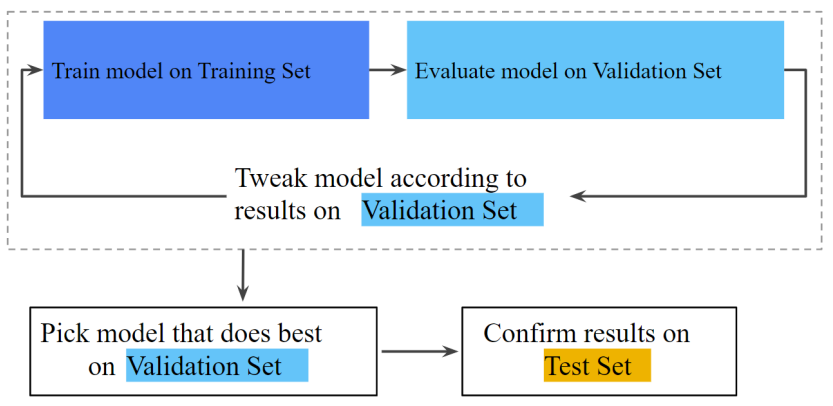

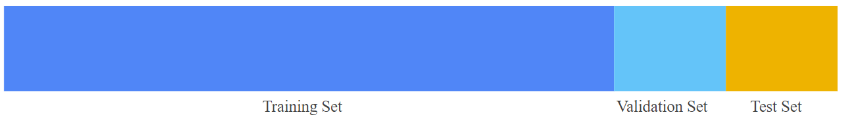

In [5]:
train_df = data.DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  data.DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = data.DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

### Normalization

Finally, normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved.

In [6]:
train_mean, train_std = train_df.normalize_data()
val_mean, val_std = val_df.normalize_data()
test_mean, test_std = test_df.normalize_data()

### Data Window

We first need to prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

We would first reshape the timeseries data into windows of 24 historical observations for each segment as the input and the PPN 15 days later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:

Starting from the beginning of the timeseries, we take the first 24 records as the 24 input features and the PPN 1 timesteps head (15 days) as the ppna we want to predict.

Shift the timeseries by one timestep and take the 24 observations from the current point as the input features and the speed 15 days ahead as the output to predict.

Keep shifting by 1 timestep and picking the 24 timestep window from the current time as input feature and the PPN 15 days ahead  as the output to predict, for the entire data.

The above steps are done for latitude and longitude. 

The function below returns the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

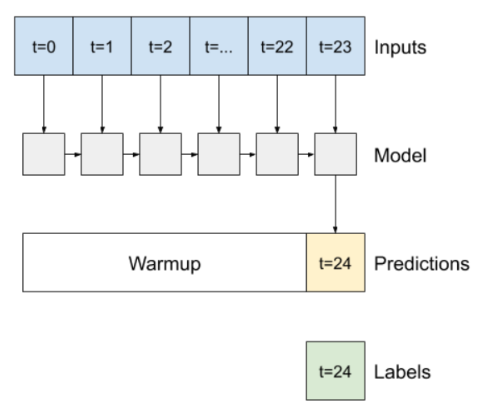

In [ ]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #The amount of days to be forecasted is given by the equation 15*OUTPUT_STEPS = # of days
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels.shape)

--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating PPN. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

The RNN technology is capable of pondering wether the inputs are correlated with eachother or not. It also has te ability to set cycles that constitute an "internal memory" that allows comparisons between the current data being analysed and the previous ones. This cycles, represented as delays, and the whole RNN structure are depicted in the following image.

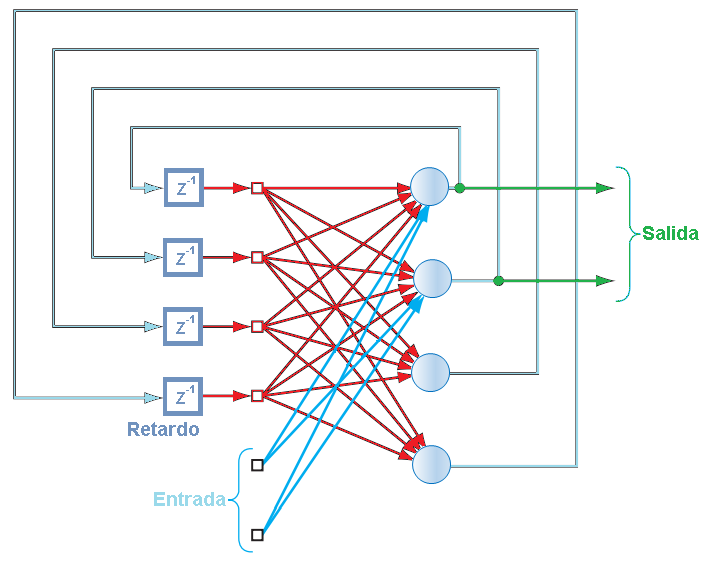



## LSTM - Multivariable 

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPN. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

Long Short Term Memory is a type of neural network designed to solve the Vanishing Gradient problem and the Exploding Gradient Problem that the basic Recurrent Neural Network posed. The structure of a single unit is 

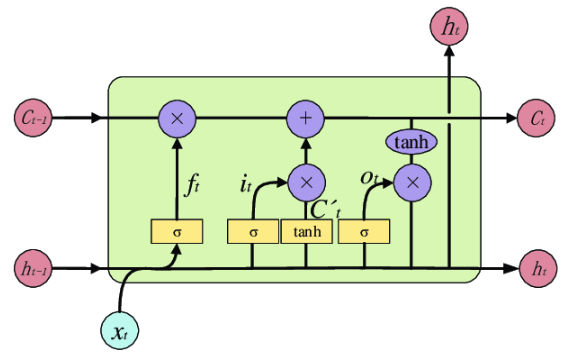

On the left side we can see the input data that arrives to the layer, which requires temporal info. x_t represents the information from the previous LSTM unit. On the right, the outputs of the unit serve as the inputs for the following step. Inside the square, the point is to make the Neural Network remember the important information and for it to "forget" the rest. As the time frame progresses, the oldest data starts to loose it's value and the LSTM unit filters it with the sigmoid functions, which act as a valve for the data flow. The tanh functions allow the new information to be passed on with a certain weight to represent it's importance.


In [7]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #The amount of days to be forecasted is given by the equation 15*OUTPUT_STEPS = # of days
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels.shape)

train sequence: (num train data, past_data, features) -> (68965, 24, 6)
label sequence: (num train data, output_steps) ->  (68965, 12)


### LSTM Multivariable Models - Parameters Tunning

In [12]:
"""
If you want to create a new model it has to be defined in /src/model
"""
input_steps, input_features, output_steps, output_features = train_sequence.shape[1], train_sequence.shape[2], train_labels.shape[1], 1
model= models.modelLstm(input_steps, output_steps, input_features, output_features)

"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""
EPOCHS = 5
history = model.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32)
model.save('../models/modelLstm128')

"""
If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
modelName = 'modelLstm128'
model = tf.keras.models.load_model(f'../models/{modelName}')
"""


Epoch 1/5

14015/14015 [==============================] - 374s 26ms/step - loss: 0.8928 - root_mean_squared_error: 0.9449 - val_loss: 0.4965 - val_root_mean_squared_error: 0.7046
Epoch 2/5
14015/14015 [==============================] - 354s 25ms/step - loss: 0.3309 - root_mean_squared_error: 0.5752 - val_loss: 0.2303 - val_root_mean_squared_error: 0.4799
Epoch 3/5
14015/14015 [==============================] - 307s 22ms/step - loss: 0.2627 - root_mean_squared_error: 0.5125 - val_loss: 0.2217 - val_root_mean_squared_error: 0.4709
Epoch 4/5
14015/14015 [==============================] - 446s 32ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994 - val_loss: 0.2211 - val_root_mean_squared_error: 0.4703
Epoch 5/5
14015/14015 [==============================] - 417s 30ms/step - loss: 0.2394 - root_mean_squared_error: 0.4892 - val_loss: 0.2241 - val_root_mean_squared_error: 0.4734
INFO:tensorflow:Assets written to: ../models/modelLstm128\assets


INFO:tensorflow:Assets written to: ../models/modelLstm128\assets


"\n#If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code \nmodelName = 'modelLstm128'\nmodel = tf.keras.models.load_model(f'../models/{modelName}')\n"

### Validation and Testing

Now we will plot the values of root mean squared error and loss for each epoch regarding the training and validation set. 

- The squared error provides a clear way to evaluate how the predictions are going to relate to the actual values. Hence, we want it as close to 0 as possible.
- The loss value, however, is not to be overlooked. It remains a key factor to determine wether the model is overfitting or not. There are two main aspects to be aware of: first, we don't want the validation loss to grow over time, as that means the model is becoming too familiar with the training data and therefore starts losing it's ability to predict. Furthermore, we want for both validation loss and training loss to be similar, as in that case the model will be accurate in predicting training labels but not anything else, resulting in overfitting.

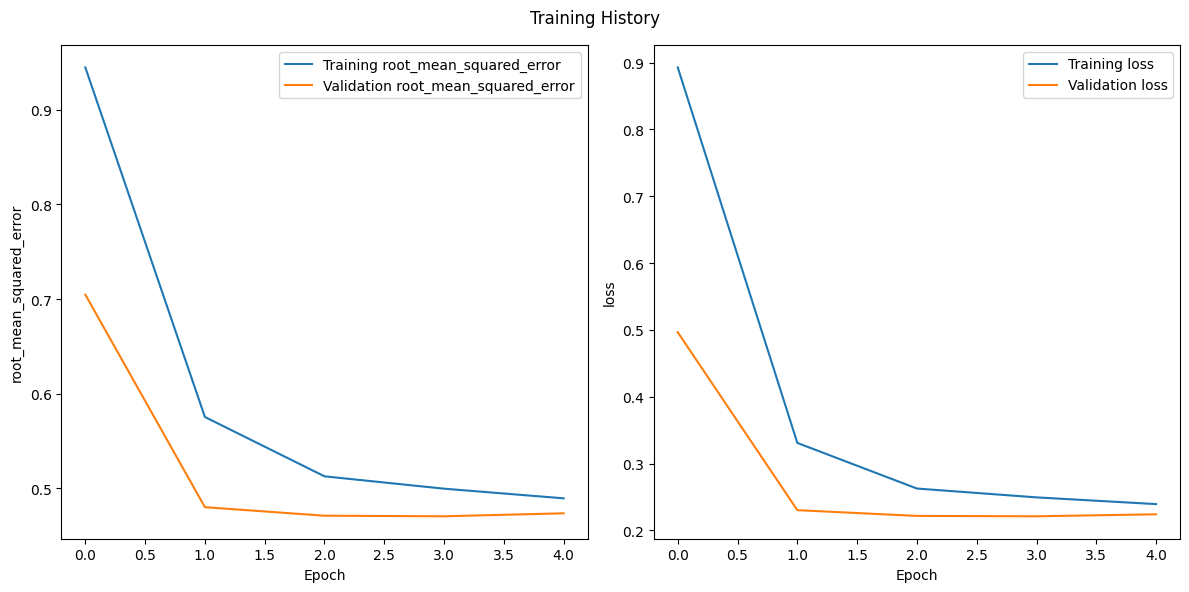

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history, "loss")

fig.suptitle("Training History")
fig.tight_layout()
plt.show()


Now it's time to see how the model behaves in the testing phase. To do so, we can plot the predicted values for a fixed position next to the measured ones for the first 6 months of the testing dataset. As the model has never seen said values before, the result may show accurately it's performance. The chosen position is completely arbitrary and can be replicated for every point in the dataset, although in theory the precission should be statistically similar.

In [16]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index,  model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index,  model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,   model, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…

## LSTM - Encoder Decoder

Sequence-to-sequence prediction problems are challenging because the number of items in the input and output sequences can vary. For example, text translation and learning to execute programs are examples of seq2seq problems.

One approach to seq2seq prediction problems that has proven very effective is called the Encoder-Decoder LSTM.

This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence. The use of the models in concert gives the architecture its name of Encoder-Decoder LSTM designed specifically for seq2seq problems.

The innovation of this architecture is the use of a fixed-sized internal representation in the heart of the model that input sequences are read to and output sequences are read from. For this reason, the method may be referred to as sequence embedding.

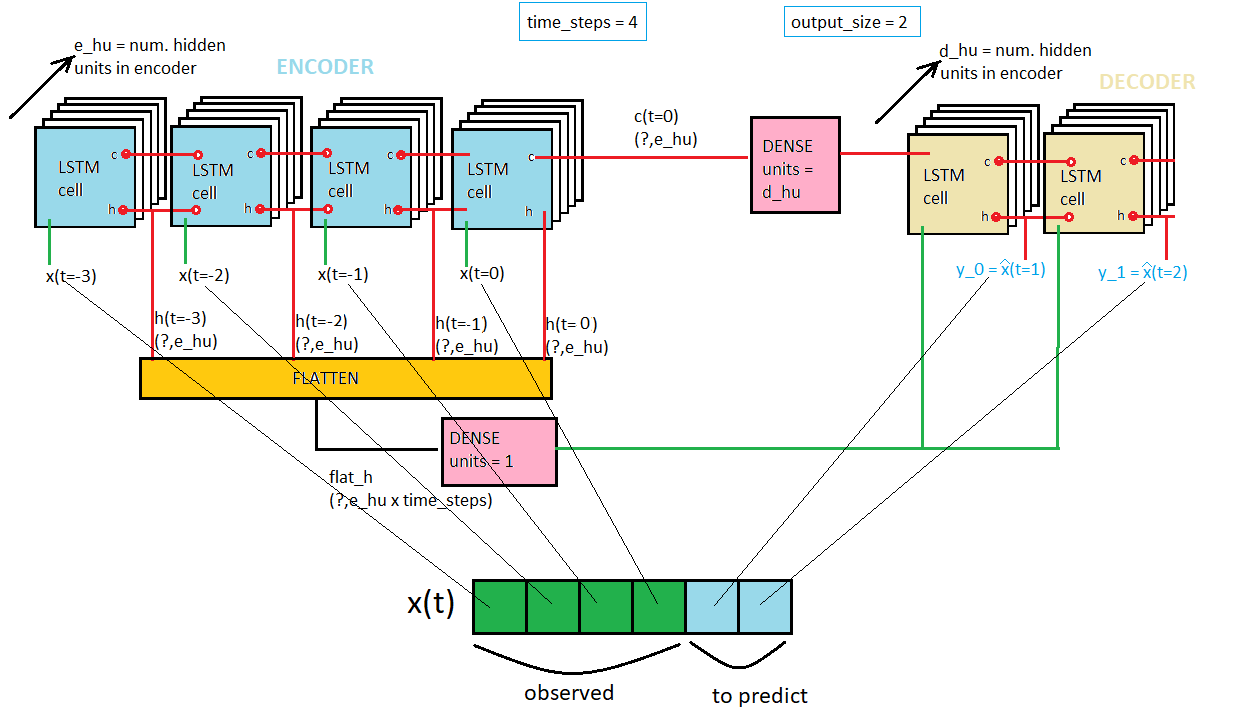

### LSTM - Encoder Decoder - Parameters Tunning

In [18]:
"""
If you want to create a new model it has to be defined in /src/model
"""
input_steps, input_features, output_steps, output_features = train_sequence.shape[1], train_sequence.shape[2], train_labels.shape[1], 1
model2 = models.modelEncoderDecoder(input_steps, output_steps, input_features, output_features)

EPOCHS = 3
history2 = model2.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32)

model2.save('../models/modelEncoderDecoder200')

"""
If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
modelName = 'modelLstm128'
model = tf.keras.models.load_model(f'../models/{modelName}')
"""

Epoch 1/3
14015/14015 [==============================] - 776s 55ms/step - loss: 0.6043 - root_mean_squared_error: 0.7774
Epoch 2/3
14015/14015 [==============================] - 610s 44ms/step - loss: 0.2488 - root_mean_squared_error: 0.4988
Epoch 3/3
14015/14015 [==============================] - 744s 53ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800
INFO:tensorflow:Assets written to: ../models/modelEncoderDecoder200\assets


INFO:tensorflow:Assets written to: ../models/modelEncoderDecoder200\assets


"\nIf you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code \nmodelName = 'modelLstm128'\nmodel = tf.keras.models.load_model(f'../models/{modelName}')\n"

### Validation and Testing

NameError: name 'hitory2' is not defined

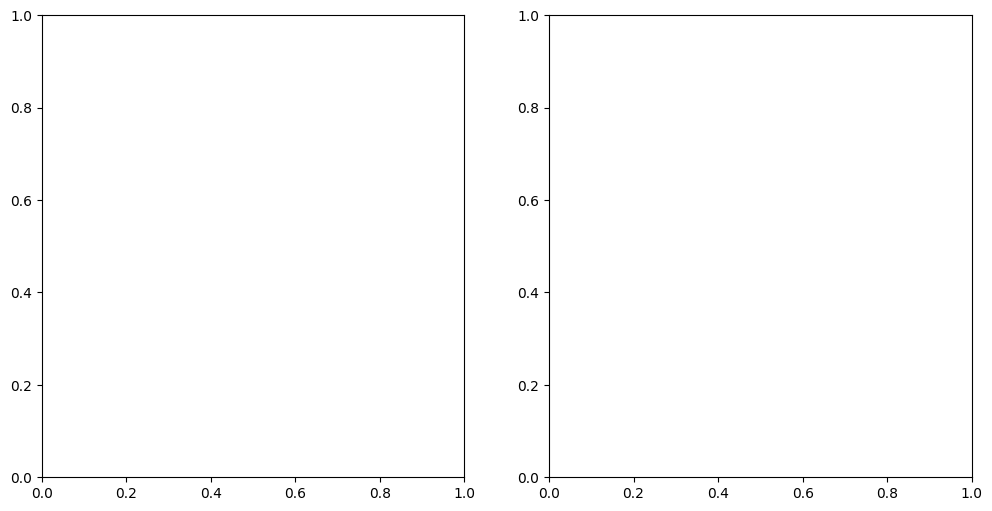

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history2, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history2, "loss")

fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [23]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, model2, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index,  model2, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index,  model2, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,   model2, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…

## Encoder-Decoder CNN-LSTM


A CNN-LSTM Encoder-Decoder network combines Convolutional Neural Network (CNN) layers for feature extraction with Long Short-Term Memory (LSTM) layers for sequence modeling. The encoder, typically consisting of CNN layers, extracts spatial features from input data. These features are then fed into the LSTM-based decoder, which learns temporal dependencies and generates sequential output. This architecture is commonly used in tasks such as image captioning, video captioning, and sequence-to-sequence translation. The CNN layers in the encoder capture spatial patterns, while LSTM layers in the decoder capture temporal relationships. This model architecture enables the network to handle input data with spatial and temporal dependencies efficiently. By integrating CNNs and LSTMs, the model can effectively process and generate sequential data with both spatial and temporal complexities

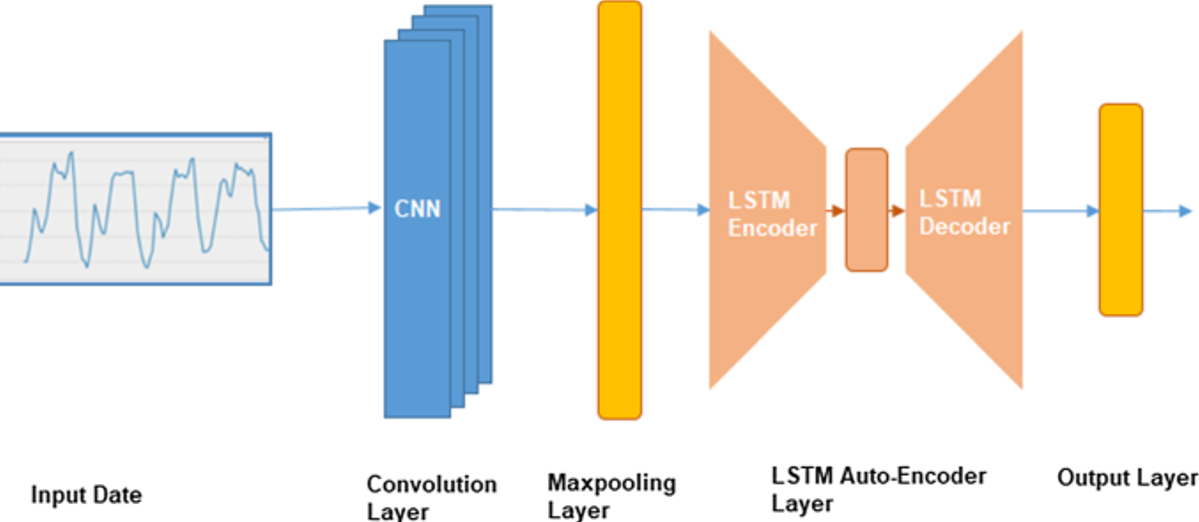

### Encoder-Decoder CNN-LSTM - Parameters Tunning

In [8]:
"""
If you want to create a new model it has to be defined in /src/model
"""
input_steps, input_features, output_steps, output_features = train_sequence.shape[1], train_sequence.shape[2], train_labels.shape[1], 1
model3 = models.modelCnnLstm(input_steps, output_steps, input_features, output_features)

EPOCHS = 3
history3 = model3.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32)

model3.save('../models/modelCnnLstm64')

"""
If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
modelName = 'modelLstm128'
model = tf.keras.models.load_model(f'../models/{modelName}')
"""




Epoch 1/3

14015/14015 [==============================] - 1259s 89ms/step - loss: 0.3374 - root_mean_squared_error: 0.5809 - val_loss: 0.2570 - val_root_mean_squared_error: 0.5069
Epoch 2/3
14015/14015 [==============================] - 1018s 73ms/step - loss: 0.2578 - root_mean_squared_error: 0.5078 - val_loss: 0.2467 - val_root_mean_squared_error: 0.4967
Epoch 3/3
14015/14015 [==============================] - 1080s 77ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900 - val_loss: 0.2617 - val_root_mean_squared_error: 0.5116
INFO:tensorflow:Assets written to: ../models/modelCnnLstm64\assets


INFO:tensorflow:Assets written to: ../models/modelCnnLstm64\assets


"\nIf you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code \nmodelName = 'modelLstm128'\nmodel = tf.keras.models.load_model(f'../models/{modelName}')\n"

### Validation and Testing

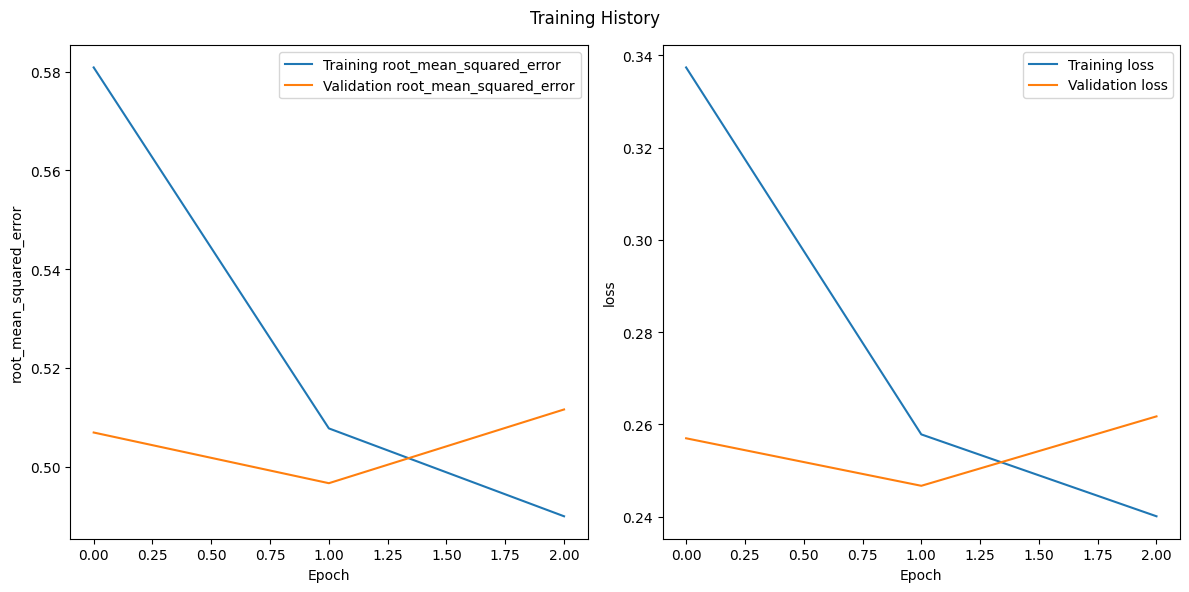

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history3, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history3, "loss")

fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [10]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df['longitude'][400000], ppna_df['latitude'][400000],index, model3, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df['longitude'][0], ppna_df['latitude'][0],index,  model3, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df['longitude'][10000], ppna_df['latitude'][10000],index,  model3, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df['longitude'][30000], ppna_df['latitude'][30000],index,   model3, test_df,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…